In [148]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.signal import savgol_filter


In [149]:
# Load the file
# data_file = Path("../Data/0.8mpers-60n-0.8pas.xlsx") # Change this to the appropriate folder/file

# data_file = Path("../Data/1.5mpers-30n-11.3pas.xlsx") 
# data_file = Path("../Data/3kn-0.5.xlsx")
# data_file = Path(r"E:\School\Year 3\cheng_lab\Data\0.3mpers-110n-11.3pas.xlsx") 
data_file = Path(r"..\Data\1mpers-20n-0.8pas.xlsx")
df = pl.read_excel(source=data_file, sheet_name="Analog")

# df = pl.read_excel(source=data_file, sheet_name="Analog #1")

In [150]:
## Parameter you can change
sampling_speed = 1000
speed = 0.3
data_point_length = speed / sampling_speed

In [151]:
## Process the file
header_names = df.columns
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
df = df.with_columns(
    x_data,
    ((16+pl.col("Voltage")) * 1000).alias("Left Gap [\u03bcm]"),
    ((16+((pl.col("Dev1/ai3")/250*1000)-4)*(10/16))*1000).alias("Right Gap [\u03bcm]"),
    (pl.col("Dev1/ai2")*112.3898+558.30904).alias("Load [N]")
)

print(df.shape[0])

15800


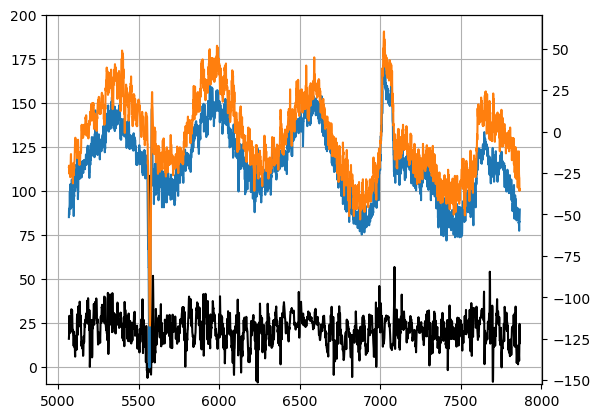

In [152]:
## Ideal Plot of What We Want

zero_point = 6467
fig, ax1 = plt.subplots()
bound = 1400
test_index = np.arange(0, df.shape[0])
ax1.plot(test_index[zero_point-bound:zero_point+bound], df["Load [N]"][zero_point-bound:zero_point+bound] - np.mean(df.select("Load [N]").head(100).to_numpy()), c='k')
ax1.set_ylim(-10, 200)
ax1.grid()

ax2 = ax1.twinx()

ax2.plot(test_index[zero_point-bound:zero_point+bound], df["Left Gap [\u03bcm]"][zero_point-bound:zero_point+bound] - df["Left Gap [μm]"][zero_point])
ax2.plot(test_index[zero_point-bound:zero_point+bound], df["Right Gap [\u03bcm]"][zero_point-bound:zero_point+bound] - df["Right Gap [μm]"][zero_point])

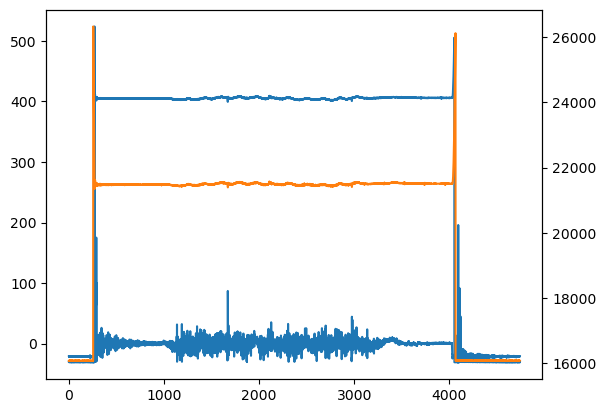

In [153]:
fig, ax1 = plt.subplots()
x_data
ax1.plot(x_data, df["Load [N]"])

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
plt.savefig(f'{data_file}.png')

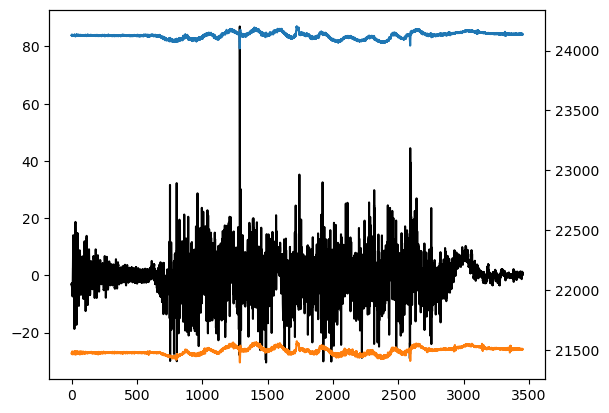

In [154]:
bound = 400
left_gap = df["Left Gap [μm]"].to_numpy()
peaks, _ = find_peaks(left_gap)

peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound *5 # Take the bound away from the file


fig, ax1 = plt.subplots()

df = df.slice(start_index, end_index) 

x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
ax1.plot(x_data, df["Load [N]"], color='k')

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
save_path =  data_file.parent / Path('Cut') / f"{data_file.name}.png"
plt.savefig(save_path)

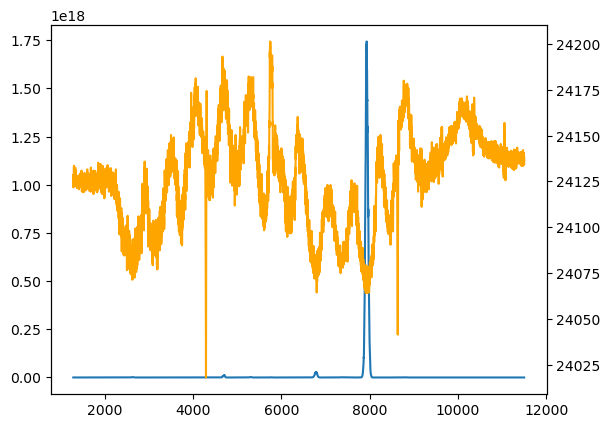

In [ ]:
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
index_array = np.arange(0, len(x_data))
load = df["Load [N]"].to_numpy()
left_gap = df["Left Gap [μm]"].to_numpy()
right_gap = df["Right Gap [μm]"].to_numpy()

def moving_product_filter(data, window_size):
    """
    Apply the Moving Product Filter to enhance weak signals in a noisy dataset.
    
    Parameters:
        data (numpy array): The input signal.
        window_size (int): The size of the moving window.
    
    Returns:
        numpy array: The filtered signal.
    """
    # Normalize data to have a mean of 0 and adjust values to be strictly positive
    data = data - np.mean(data)
    data = np.abs(data) / np.max(np.abs(data))  # Normalize with respect to absolute value
    data = data + 1  # Adjust mean to 1
    
    # Apply the moving product filter
    filtered_signal = np.ones_like(data)
    half_window = window_size // 2

    for i in range(half_window, len(data) - half_window):
        filtered_signal[i] = np.prod(data[i - half_window : i + half_window + 1])

    return filtered_signal

window_size = 100
filtered_left = moving_product_filter(left_gap[start_index:end_index], window_size)
filtered_right = moving_product_filter(right_gap[start_index:end_index], window_size)
filtered_load = moving_product_filter(load - np.mean(load[:100]), window_size)

fig, ax = plt.subplots()
ax.plot(index_array[start_index:end_index], filtered_left)
ax2 = ax.twinx()

ax2.plot(index_array[start_index:end_index], left_gap[start_index:end_index], c='orange')

C:\Users\gyang\AppData\Local\Temp\ipykernel_27112\1028531469.py:26: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel = gaussian(window_size, std_dev)


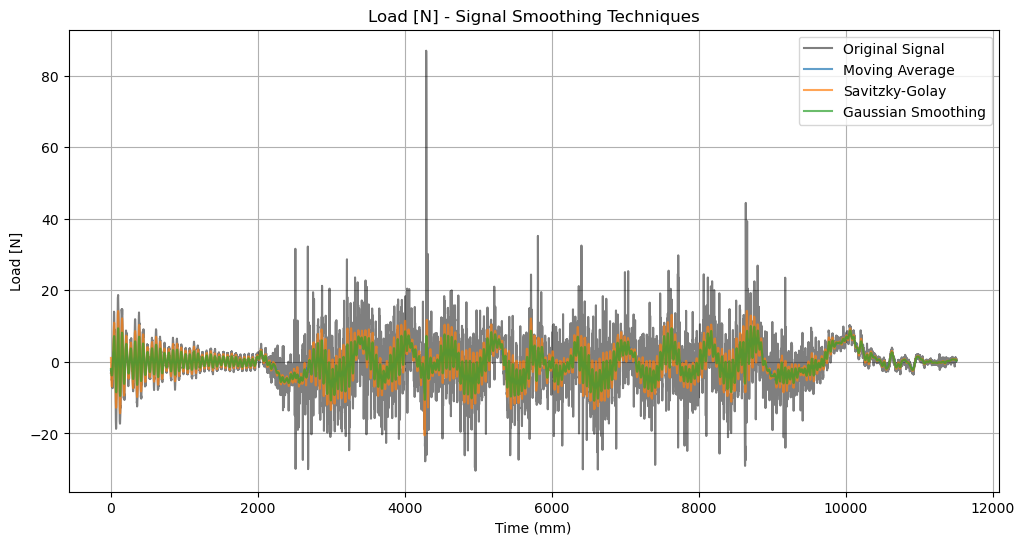

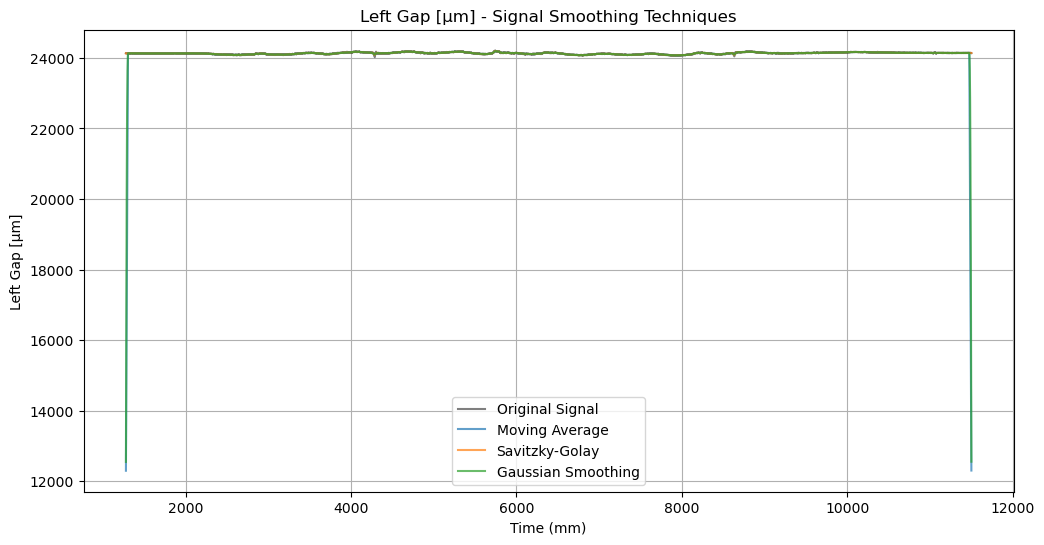

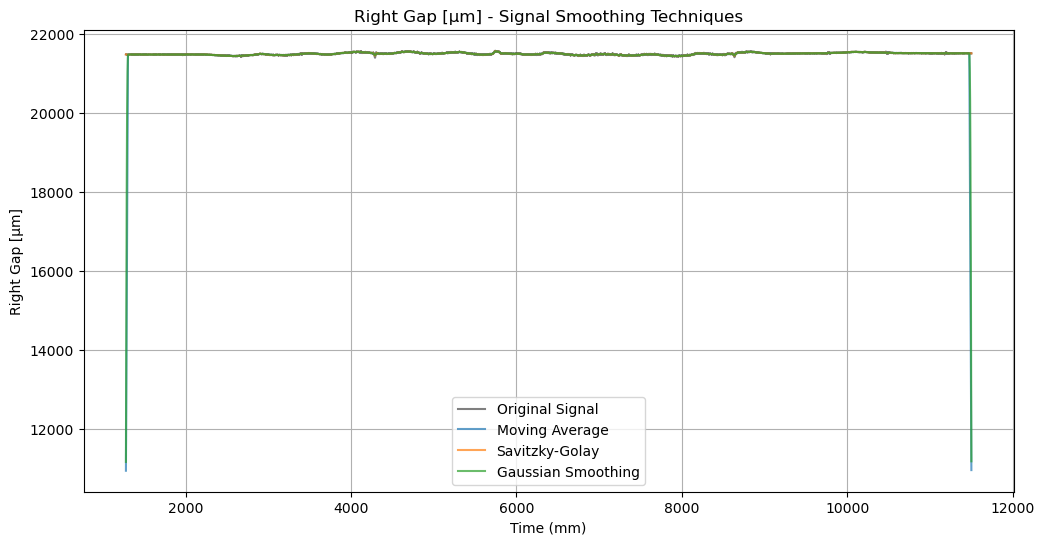

In [156]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, gaussian, convolve

# Prepare the data
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
load = df["Load [N]"]
left_gap = df["Left Gap [μm]"]
right_gap = df["Right Gap [μm]"]

# Define smoothing parameters
window_size = 51  # Odd number for symmetric smoothing
poly_order = 3  # Polynomial order for Savitzky-Golay
std_dev = 10  # Standard deviation for Gaussian filter

# Function to smooth and plot a signal
def smooth_and_plot(signal, time, signal_label):
    # Moving Average Smoothing
    moving_avg = np.convolve(signal, np.ones(window_size)/window_size, mode='same')

    # Savitzky-Golay Filter
    savgol = savgol_filter(signal, window_length=window_size, polyorder=poly_order)

    # Gaussian Filter
    gaussian_kernel = gaussian(window_size, std_dev)
    gaussian_kernel /= np.sum(gaussian_kernel)
    gaussian_smoothed = convolve(signal, gaussian_kernel, mode='same')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, label="Original Signal", alpha=0.5, color="black")
    plt.plot(time, moving_avg, label="Moving Average", alpha=0.7)
    plt.plot(time, savgol, label="Savitzky-Golay", alpha=0.7)
    plt.plot(time, gaussian_smoothed, label="Gaussian Smoothing", alpha=0.7)
    plt.xlabel("Time (mm)")
    plt.ylabel(f"{signal_label}")
    plt.title(f"{signal_label} - Signal Smoothing Techniques")
    plt.legend()
    plt.grid()
    plt.show()

# Convert all signals to NumPy arrays
index_array = np.arange(0, len(x_data))
# time = x_data.to_numpy()
time = index_array
load_signal = load.to_numpy()
left_gap_signal = left_gap.to_numpy()
right_gap_signal = right_gap.to_numpy()

# Plot each signal with smoothing
smooth_and_plot(load_signal, time, "Load [N]")
smooth_and_plot(left_gap_signal[start_index:end_index], time[start_index:end_index], "Left Gap [μm]")
smooth_and_plot(right_gap_signal[start_index:end_index], time[start_index:end_index], "Right Gap [μm]")


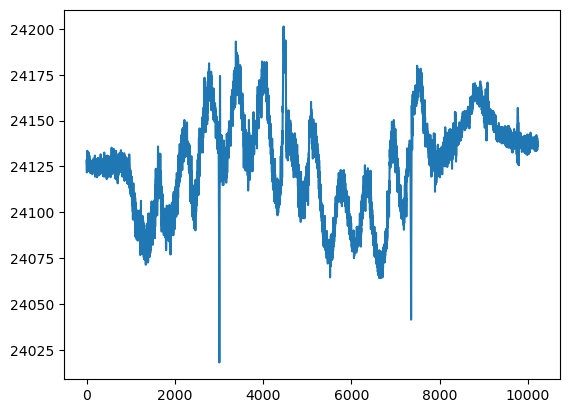

In [157]:
plt.plot(left_gap_signal[start_index:end_index])

C:\Users\gyang\AppData\Local\Temp\ipykernel_27112\4000986316.py:22: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel = gaussian(window_size, std_dev)


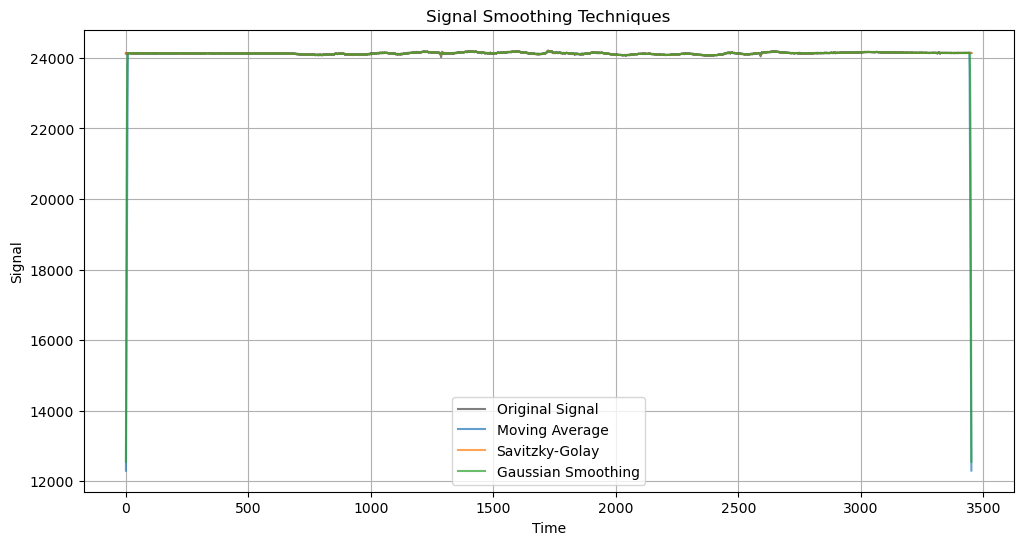

In [158]:
from scipy.signal import savgol_filter, gaussian, convolve

x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
load = df["Load [N]"]
left_gap = df["Left Gap [μm]"]
right_gap = df["Right Gap [μm]"]

# Assuming data contains a time column and a signal column
time = x_data.to_numpy()  # Convert Polars Series to NumPy array
signal = left_gap.to_numpy()

# Moving Average Smoothing (using NumPy)
window_size = 51  # Odd number for symmetric smoothing
moving_avg = np.convolve(signal, np.ones(window_size)/window_size, mode='same')

# Savitzky-Golay Filter
poly_order = 3  # Polynomial order for fitting
savgol = savgol_filter(signal, window_length=window_size, polyorder=poly_order)

# Gaussian Filter
std_dev = 10  # Standard deviation for Gaussian filter
gaussian_kernel = gaussian(window_size, std_dev)
gaussian_kernel /= np.sum(gaussian_kernel)
gaussian_smoothed = convolve(signal, gaussian_kernel, mode='same')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time, signal, label="Original Signal", alpha=0.5, color="black")
plt.plot(time, moving_avg, label="Moving Average", alpha=0.7)
plt.plot(time, savgol, label="Savitzky-Golay", alpha=0.7)
plt.plot(time, gaussian_smoothed, label="Gaussian Smoothing", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Signal Smoothing Techniques")
plt.legend()
plt.grid()
plt.show()

Steady portion found from index 18 to 9502
Average Value: 24123.68


C:\Users\gyang\AppData\Local\Temp\ipykernel_27112\3080662804.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')


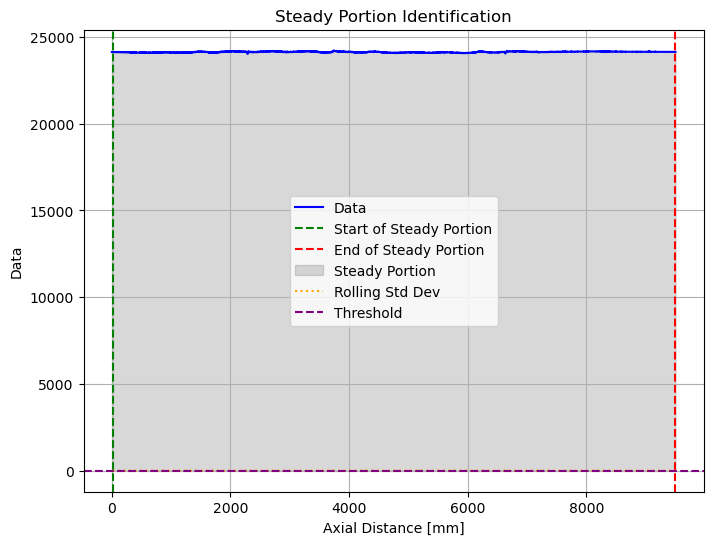

In [159]:
def find_steady_portion(axial_distance, data, window_size=10, threshold=2):
    """
    Finds the steady portion of the data and calculates the average for that section.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze (e.g., left_gap, load, etc.).
        window_size (int): Window size for calculating the rolling standard deviation.
        threshold (float): Threshold for identifying the steady portion based on standard deviation.

    Returns:
        tuple: (start_index, end_index, average_value, steady_axial_distance, steady_data)

    Example:
        >>> start_idx, end_idx, avg, x_steady, data_steady = find_steady_portion(x, data)
    """
    # Step 1: Calculate rolling standard deviation
    rolling_std = pd.Series(data).rolling(window=window_size, center=True).std()

    # Handle NaN in rolling_std by forward/backward filling
    rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')

    # Step 2: Identify steady-state range using the threshold
    steady_indices = rolling_std[rolling_std < threshold].index

    # Step 3: Find the start and end of the steady portion
    if len(steady_indices) > 0:
        start_idx = steady_indices[0]
        end_idx = steady_indices[-1]

        # Step 4: Filter data within this range
        steady_axial_distance = axial_distance[start_idx:end_idx+1]
        steady_data = data[start_idx:end_idx+1]

        # Compute averages
        average_value = np.mean(steady_data[0])
        return start_idx, end_idx, average_value, steady_axial_distance, steady_data
    else:
        print("No steady portion found with the given threshold.")
        return None, None, None, None, None

# Example usage
# Replace these with your actual data
left_gap = df["Left Gap [μm]"][2000:12000]
axial_distance = np.arange(0, len(left_gap))  # Example axial distance data

# Call the function
start_idx, end_idx, avg_value, steady_axial, steady_data = find_steady_portion(axial_distance, left_gap, window_size=20, threshold=2)

if start_idx is not None:
    print(f"Steady portion found from index {start_idx} to {end_idx}")
    print(f"Average Value: {avg_value:.2f}")

    # Plot the original data
    plt.figure(figsize=(8, 6))
    plt.plot(axial_distance, left_gap, label="Data", color='blue')
    plt.axvline(axial_distance[start_idx], color='green', linestyle='--', label="Start of Steady Portion")
    plt.axvline(axial_distance[end_idx], color='red', linestyle='--', label="End of Steady Portion")
    plt.fill_between(axial_distance[start_idx:end_idx+1], 
                     left_gap[start_idx:end_idx+1], 
                     alpha=0.3, color='gray', label="Steady Portion")
    
    # Overlay rolling standard deviation
    rolling_std = pd.Series(left_gap).rolling(window=20, center=True).std()
    plt.plot(axial_distance, rolling_std, color='orange', linestyle=':', label="Rolling Std Dev")
    plt.axhline(y=2, color='purple', linestyle='--', label="Threshold")
    
    plt.xlabel("Axial Distance [mm]")
    plt.ylabel("Data")
    plt.title("Steady Portion Identification")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No steady portion was identified. Adjust the threshold or window size.")

ColumnNotFoundError: "load" not found

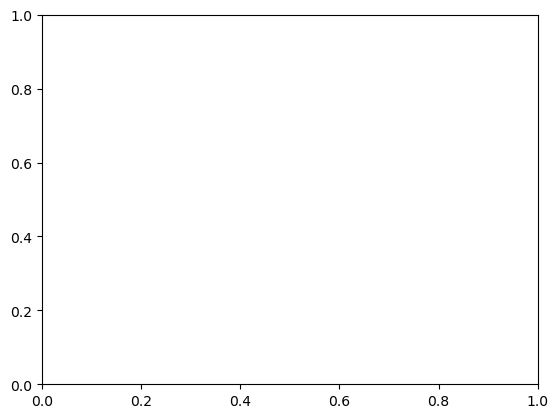

In [160]:
fig, ax1 = plt.subplots()

x_data = x_data[start_idx:end_idx]
ax1.plot(x_data, df["load"][start_idx:end_idx])

ax2 = ax1.twinx()

ax2.plot(x_data, df["left_gap"][start_idx:end_idx])
ax2.plot(x_data, df["right_gap"][start_idx:end_idx])
plt.savefig(f'{data_file}.png')

In [ ]:

def find_offset_portion(df, bound = 200):
    # Remove the two peaks first
    left_gap = df["Left Gap [μm]"].to_numpy()
    peaks, _ = find_peaks(left_gap)

    peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
    outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

    start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound # Take the bound away from the file

    # Refining data points again
    left_gap = left_gap[start_index:end_index]
    offset_pos = start_index
    end_pos = end_index

    peaks, _ = find_peaks(left_gap)
    peak = sorted(peaks, key = lambda x : left_gap[x], reverse=True)[0]
    start_index, end_index = peak - bound, peak + bound # The area we want to analyze
    left_gap = left_gap[start_index:end_index]
    offset_pos += start_index
    end_pos = end_index

    x_range = 2 * bound
    load = df["Load [N]"][offset_pos:offset_pos+x_range].to_numpy()
    left_gap = df["Left Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
    right_gap = df["Right Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
    x = df["Axial Distance [mm]"][offset_pos:offset_pos+x_range].to_numpy()


    load_peaks, _ = find_peaks(load)
    zero_pos = sorted(load_peaks, key = lambda x : load[x], reverse=True)[0]

    left_gap = left_gap - left_gap[zero_pos]
    right_gap = right_gap - right_gap[zero_pos]
    x = x - x[zero_pos]

    load_offset = np.mean(df.select("Load [N]").head(100).to_numpy())
    load_no_off = load
    load = load - load_offset 
    print(load_offset)

    return(x, left_gap, right_gap, load, load_no_off)

In [ ]:
distance, left_gap, right_gap, load, zero_pos = find_offset_portion(df)

-23.860765446467145


In [ ]:
def find_steady_portion_with_gradient(axial_distance, data, window_size=10, polyorder=2, gradient_threshold=10):
    """
    Finds the steady portion using gradient analysis and Savitzky-Golay smoothing.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze.
        window_size (int): Window size for smoothing.
        polyorder (int): Polynomial order for Savitzky-Golay filter.
        gradient_threshold (float): Threshold for identifying edges based on gradient.

    Returns:
        dict: Dictionary with edge indices, steady portion indices, and steady average.
    """
    # Step 1: Smooth the data using Savitzky-Golay filter
    smoothed_data = savgol_filter(data, window_length=window_size, polyorder=polyorder)

    # Step 2: Calculate the gradient of the smoothed data
    gradient = np.gradient(smoothed_data, axial_distance)

    # Step 3: Identify rising and lowering edges using gradient thresholds
    rising_edge_idx = np.where(gradient > gradient_threshold)[0][0]  # First large positive slope
    lowering_edge_idx = np.where(gradient < -gradient_threshold)[0][-1]  # Last large negative slope

    # Step 4: Define the steady portion as the region between edges
    steady_start_idx = rising_edge_idx + 1  # Start after the rising edge
    steady_end_idx = lowering_edge_idx - 1  # End before the lowering edge

    if steady_start_idx < steady_end_idx:
        # Filter steady portion
        steady_axial = axial_distance[steady_start_idx:steady_end_idx + 1]
        steady_data = data[steady_start_idx:steady_end_idx + 1]
        steady_average = np.mean(steady_data)

        return {
            "rising_edge_idx": rising_edge_idx,
            "lowering_edge_idx": lowering_edge_idx,
            "steady_start_idx": steady_start_idx,
            "steady_end_idx": steady_end_idx,
            "steady_average": steady_average,
            "steady_axial": steady_axial,
            "steady_data": steady_data,
        }
    else:
        print("No valid steady portion found.")
        return None
    


In [ ]:
image_name = "result.png"

# Analyze steady portions for both left_gap and right_gap
result_left = find_steady_portion_with_gradient(distance, left_gap, window_size=21, polyorder=2, gradient_threshold=5)
result_right = find_steady_portion_with_gradient(distance, right_gap, window_size=21, polyorder=2, gradient_threshold=5)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Load on the primary y-axis
ax1.plot(distance, load, color="black", label="Load (N)")
ax1.set_xlabel("Axial Distance (mm)")
ax1.set_ylabel("Load (N)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_ylim(0, 200)
ax1.grid()



# Create a secondary y-axis for Left Gap and Right Gap
ax2 = ax1.twinx()
ax2.plot(distance, left_gap, color="red", label="Left Gap (μm)")
ax2.plot(distance, right_gap, color="blue", label="Right Gap (μm)")
ax2.set_ylabel("Gap (μm)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
# ax2.set_ylim(-100, 200)

# Highlight the steady portion for left_gap
if result_left:
    ax2.fill_between(
        distance[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1],
        left_gap[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1],
        alpha=0.3, color="lightgreen"
    )
else:
    print("Did not find steady state, change parameter")

# Highlight the steady portion for right_gap
if result_right:
    ax2.fill_between(
        distance[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1],
        right_gap[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1],
        alpha=0.3, color="orange"
    )
else:
    print("Did not find steady state, change parameter")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Title and show the plot
plt.title("Axial Distances vs Load and Gaps")

plt.savefig(image_name, format="png", dpi=300) 
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
output_file = "gap_averages.txt"

steady_mean = [
    result_left['steady_average'] if result_left else None,
    result_right['steady_average'] if result_right else None
]

# Extract steady portions
gap_mean = [
    np.mean(left_gap[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1]) if result_left else None,
    np.mean(right_gap[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1]) if result_right else None
]

with open(output_file, "w") as f:
    # Write the steady averages
    f.write(f"Left Gap Steady Average: {steady_mean[0]:.2f} μm\n")
    f.write(f"Right Gap Steady Average: {steady_mean[1]:.2f} μm\n\n")
    
    # Write the gap averages
    if gap_mean[0] is not None:
        f.write(f"Left Gap Average: {gap_mean[0]:.2f} μm\n")
    else:
        f.write("No steady portion data available for Left Gap.\n")
    
    if gap_mean[1] is not None:
        f.write(f"Right Gap Average: {gap_mean[1]:.2f} μm\n")
    else:
        f.write("No steady portion data available for Right Gap.\n")

In [ ]:
print(f'Left Gap Steady Average: {steady_mean[0]:.2f} μm')
print(f'Right Gap Steady Average: {steady_mean[1]:.2f} μm')
print()
print(f'Left Gap Average: {gap_mean[0]:.2f} μm')
print(f'Right Gap Average: {gap_mean[1]:.2f} μm')

Left Gap Steady Average: 192.54 μm
Right Gap Steady Average: 196.98 μm

Left Gap Average: 192.54 μm
Right Gap Average: 196.98 μm
